In [154]:
import numpy as np
import pandas as pd
import rioxarray as rxa

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pathlib import Path

import skgstat as skg

from tqdm import tqdm

from itertools import product

np.random.seed(42)

# home_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/')
home_dir = Path('/bsuhome/zacharykeskinen/uavsar-coherence/')
fig_dir = home_dir.joinpath('figures', 'variograms')

uavsar_dir = Path('/bsuhome/zacharykeskinen/scratch/coherence/uavsar/tiffs/')

# get list of uavsars directories
uavsars = list(uavsar_dir.glob('*')) # sorted
# get only one site
# uavsars = [u for u in uavsars if u.stem.split('_')[0] == 'lowman']
# get location and flight direction for key and first coherence tiff as value of dictionary
uavsars = {u.stem: list(u.glob('*.cor.grd.tiff')) for u in uavsars if len(list(u.glob('*.cor.grd.tiff'))) > 0}

# figure out max and min dt
max_dt = 0
min_dt = 100
for uavsar, fps in uavsars.copy().items():
    fp = fps[0]
    ann = pd.read_csv(list(fp.parent.glob('*.csv'))[0], index_col = 0)
    t1, t2 = ann.loc['value', 'start time of acquisition for pass 1'], ann.loc['value', 'start time of acquisition for pass 2']
    t1, t2 = [pd.to_datetime(t) for t in [t1, t2]]
    dt = t2 - t1
    if dt.days > 100: uavsars.pop(uavsar); continue
    if dt.days < 2: uavsars.pop(uavsar); continue
    if dt.days > max_dt: max_dt = dt.days
    if dt.days < min_dt: min_dt = dt.days

dt_cmap = mpl.colormaps.get_cmap('plasma')
dt_norm = mpl.colors.Normalize(min_dt, max_dt)

t_cmap = plt.cm.get_cmap('Greens', 7)
t_norm = mpl.colors.Normalize(1, 7)


/tmp/ipykernel_118819/4083590331.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  t_cmap = plt.cm.get_cmap('Greens', 7)


In [155]:
def prep_img(fp, crop = True):
    img = rxa.open_rasterio(fp).squeeze('band', drop = True)
    img = img.rio.write_crs('EPSG:4326').rio.reproject(dst_crs = img.rio.estimate_utm_crs())
    img = img.where((img > 0) & (img < 1))
    # crop out center 10km
    if crop:
        img = img.sel(x = slice(img.x.mean() - 5000, img.x.mean() + 5000), y = slice(img.y.mean() + 5000, img.y.mean() - 5000))
    img = img.dropna('x', how = 'all').dropna('y', how = 'all')
    return img

def get_coord_values(img, n_samples = 100):
    coords = list(product(np.random.choice(img.x, round(n_samples**0.5)), np.random.choice(img.y, round(n_samples**0.5))))
    values = np.array([img.sel(x = x, y = y).values for x, y in coords]).ravel()
    coords, values = np.array(coords)[~np.isnan(values)], values[~np.isnan(values)]

    return coords, values

def get_winter_month(month, start_month = 10):
    if month >= start_month: return month - start_month
    else: return month + (12- start_month)

stlake


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


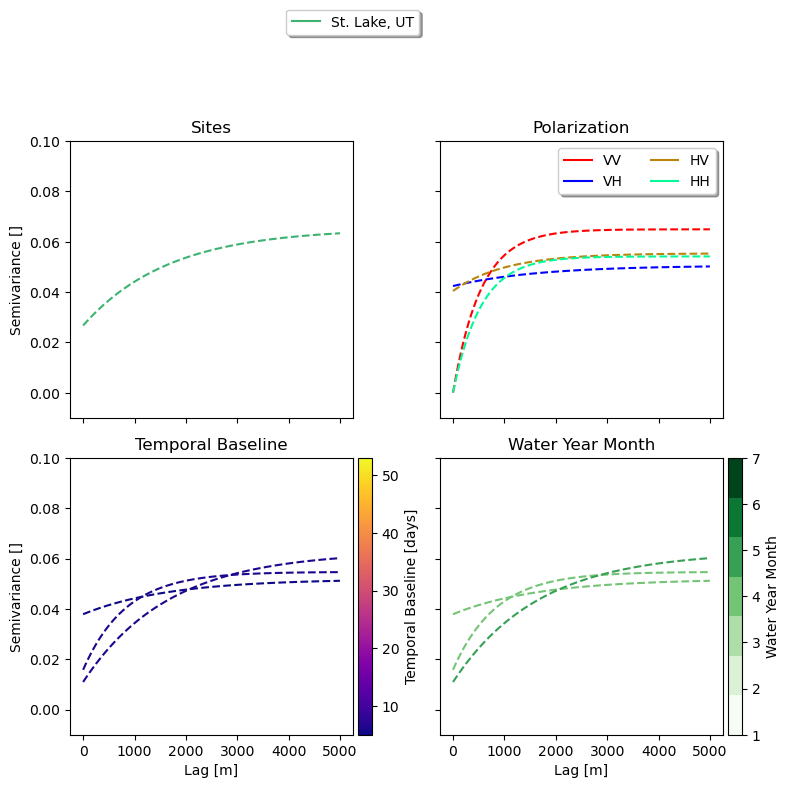

In [162]:
loc_colors = {'grmesa': {'color': 'mediumspringgreen', 'name': 'Grand Mesa, CO'}, 'stlake': {'color': 'mediumseagreen', 'name': 'St. Lake, UT'}, 'rockmt': {'color': 'orange', 'name': 'Rocky Mountain NP, CO'}, \
    'irnton': {'color':'darkorchid', 'name': 'Ironton, CO'}, 'sierra': {'color':'lightskyblue', 'name':'Sierra, CA'}, 'fraser': {'color':'cornflowerblue','name': 'Fraser, CO'}, \
        'lowman': {'color': 'pink', 'name': 'Lowman, ID'}, 'silver': {'color': 'darkgoldenrod', 'name': 'Reynold Creek, ID'}, 'uticam': {'color':'navy', 'name': 'Uticam, MT'}, 'peeler': {'color': 'indianred', 'name':'Peeler, CO'},\
        'alamos': {'color': 'magenta', 'name': 'Alamos, NM'}, 'donner': {'color': 'mediumturquoise', 'name': 'Donner, CA'}, 'dorado': {'color': 'slategrey', 'name': 'Dorado, CA'}}

pol_cols = {'VV':'red', 'HH':'mediumspringgreen', 'VH': 'blue', 'HV': 'darkgoldenrod'}

# variogram parameters
n_lags = 1000
bin_func = 'uniform'
model = 'exponential'
max_lag = 5000

fig, axes = plt.subplots(2, 2, figsize = (8, 8))

for loc, d in loc_colors.items():
    # if loc != 'stlake': continue
    print(loc)
    color, name = d['color'], d['name']
    loc_coords, loc_values = np.array([[],[]]).T, np.array([])
    pol_coords, pol_values = {pol: np.array([[], []]).T for pol in ['VV', 'VH', 'HV', 'HH']}, {pol: np.array([]) for pol in ['VV', 'VH', 'HV', 'HH']}

    loc_uavsars = {k:v for k,v in uavsars.items() if loc in k}
    
    for i, (uavsar, fps) in enumerate(tqdm(loc_uavsars.items())):
        full_pol_fps = fps.copy()
        # if i > 2: continue

        fps = [fp for fp in fps if 'HH_' in fp.stem]
        if len(fps) != 1: continue
        fp = fps[0]

        locs = uavsar.split('_')[0]
        
        img = prep_img(fp)

        coords, values = get_coord_values(img)
        loc_coords = np.concatenate([loc_coords, coords])
        loc_values = np.concatenate([loc_values, values])

        # select examples site
        if loc != 'stlake': continue
        
        ann = pd.read_csv(list(fp.parent.glob('*.csv'))[0], index_col = 0)
        t1, t2 = ann.loc['value', 'start time of acquisition for pass 1'], ann.loc['value', 'start time of acquisition for pass 2']
        t1, t2 = [pd.to_datetime(t) for t in [t1, t2]]
        dt = t2 - t1

        # plot temporal baseline variograms
        ax = axes.ravel()[2]
        V = skg.Variogram(coords, values, n_lags = n_lags, bin_func = bin_func, use_nugget = True, model = model, maxlag = max_lag) # maxlag = 20000, n_lags = 100,
        V.plot(axes = ax, grid = False, show = False, hist = False)
        [l.set_color(dt_cmap(dt_norm(dt.days))) for l in ax.get_lines()[-2:]]

        # plot month of winter
        ax = axes.ravel()[3]
        winter_month = get_winter_month(t1.month)
        V.plot(axes = ax, grid = False, show = False, hist = False)
        [l.set_color(t_cmap(winter_month)) for l in ax.get_lines()[-2:]]

        for ax in axes.ravel()[2:4]:
            lns = ax.get_lines()
            lns[-2].set_visible(False)
            lns[-1].set_linestyle('--')

        # get all the polarizations and add their coords/values to dictionary of coords
        for pol in list(pol_coords.keys()):
            pol_fps = [fp for fp in full_pol_fps if f'{pol}_' in fp.stem]
            if len(pol_fps) != 1: continue
            pol_fp = pol_fps[0]

            pol_img = prep_img(pol_fp)
            coords, values = get_coord_values(pol_img)
            pol_coords[pol] = np.concatenate([pol_coords[pol], coords])
            pol_values[pol] = np.concatenate([pol_values[pol], values])

        
    # location plotting variograms
    ax = axes.ravel()[0]
    V = skg.Variogram(loc_coords, loc_values, n_lags = n_lags, bin_func = bin_func, use_nugget = True, model = model, maxlag = max_lag) # maxlag = 20000, n_lags = 100,
    V.plot(axes = ax, grid = False, show = False, hist = False)
    lns = ax.get_lines()
    [l.set_color(color) for l in lns[-2:]]
    lns[-2].set_visible(False)
    lns[-1].set_linestyle('--')
    ax.plot([], [], color = color, label = name, alpha = 1)

    # select example site
    if loc != 'stlake': continue

    # plot polarizaton variograms
    for (pol1, c), (pol2, v) in zip(pol_coords.items(), pol_values.items()):
        assert pol1 == pol2
        ax = axes.ravel()[1]
        V = skg.Variogram(c, v, n_lags = n_lags, bin_func = bin_func, use_nugget = True, model = model, maxlag = max_lag) # maxlag = 20000, n_lags = 100,
        V.plot(axes = ax, grid = False, show = False, hist = False)
        lns = ax.get_lines()
        [l.set_color(pol_cols[pol1]) for l in lns[-2:]]
        lns[-2].set_visible(False)
        lns[-1].set_linestyle('--')
        ax.plot([], [], color = pol_cols[pol1], label = pol1, alpha = 1)
    
    # add colorbars
    for ax in axes.ravel()[:2]: divider = make_axes_locatable(ax); cax = divider.append_axes('right', size='5%', pad=0.05); cax.axis('off')
    # temporal baselines
    ax = axes.ravel()[2]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(mpl.cm.ScalarMappable(norm=dt_norm, cmap=dt_cmap), cax=cax, orientation='vertical', label = 'Temporal Baseline [days]')
    ax.set_title('Temporal Baseline')
    ax = axes.ravel()[3]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(mpl.cm.ScalarMappable(cmap= t_cmap, norm = t_norm), cax=cax, orientation='vertical', label = 'Water Year Month')
    ax.set_title('Water Year Month')




axes[0, 0].legend(ncols = 3, loc='upper center', bbox_to_anchor=(1, 1.5),fancybox=True, shadow=True)
axes[0, 0].set_title('Sites')

axes[0, 1].legend(ncols = 2, loc='best',fancybox=True, shadow=True)
axes[0, 1].set_title('Polarization')

for ax in axes.ravel():
    ax.set_ylim(-0.01, 0.1)

for ax in axes[:, 1:].ravel(): 
    ax.set_yticklabels([])
    ax.set_ylabel('')

for ax in axes[0, :].ravel(): 
    ax.set_xticklabels([])
    ax.set_xlabel('')

for ax in axes[:, 0].ravel(): 
    ax.set_ylabel('Semivariance []')
for ax in axes[1, :].ravel(): 
    ax.set_xlabel('Lag [m]')

plt.tight_layout()
fig.savefig(fig_dir.joinpath('variograms.png'))
